#Create the environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/ESoWC

/content/drive/My Drive/ESoWC


In [3]:
import pandas as pd
import xarray as xr
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from sklearn.feature_selection import VarianceThreshold

#Upload the dataset

Note, we exclude "cvl" and "cvh" since we get them from another dataset

In [4]:
dataset = xr.open_dataset('MAY_HOURLY_2019_NOX_and_weather.nc')
dataset = dataset.sortby(['latitude','longitude','time'])  
dataframe = dataset.to_dataframe()
dataframe = dataframe.reset_index()
dataframe.head()

,latitude,longitude,time,EMISSIONS_2019,u10,v10,hcc,lcc,tcc,cvl,cvh,sp,tmp,sp_hum,rel_hum,tcwv,tcw,tot_wind
0,43.0,4.0,2019-05-01 01:00:00,1.150046e-12,2.960762,-5.035299,0.0,0.045595,0.046689,0.0,2.980232e-08,101555.250000,263.693481,0.000004,0.000227,14.677999,14.682165,5.914585
1,43.0,4.0,2019-05-01 02:00:00,7.820315e-13,3.289431,-4.350558,0.0,0.048083,0.050270,0.0,2.980232e-08,101520.179688,263.244812,0.000004,0.000235,14.246251,14.249586,5.532602
2,43.0,4.0,2019-05-01 03:00:00,6.900278e-13,3.618101,-3.665817,0.0,0.050570,0.053851,0.0,2.980232e-08,101485.117188,262.796143,0.000004,0.000243,13.814503,13.817007,5.150619
3,43.0,4.0,2019-05-01 04:00:00,6.440259e-13,3.346790,-3.465523,0.0,0.035199,0.038485,0.0,2.980232e-08,101505.007812,262.032562,0.000004,0.000264,13.644949,13.647179,4.818472
4,43.0,4.0,2019-05-01 05:00:00,7.820315e-13,3.075480,-3.265230,0.0,0.019827,0.023118,0.0,2.980232e-08,101524.890625,261.268951,0.000004,0.000284,13.475395,13.477350,4.486325


In [5]:
all_name = ["EMISSIONS_2019","u10","v10","hcc","lcc","tcc","sp","tmp","sp_hum","rel_hum","tcwv","tcw","tot_wind"]
x_name = ["u10","v10","hcc","lcc","tcc","sp","tmp","sp_hum","rel_hum","tcwv","tcw","tot_wind"]
y_name = ["EMISSIONS_2019"]

In [6]:
scaler = MinMaxScaler()

df_norm =  pd.DataFrame(scaler.fit_transform(dataframe[all_name]), columns=dataframe[all_name].columns)
df_norm.head()

,EMISSIONS_2019,u10,v10,hcc,lcc,tcc,sp,tmp,sp_hum,rel_hum,tcwv,tcw,tot_wind
0,0.000441,0.515923,0.430374,5.551083e-17,0.045595,0.046689,0.923303,0.188289,0.000000,0.63961,0.360875,0.353796,0.304495
1,0.000299,0.530493,0.456249,5.551083e-17,0.048083,0.050270,0.921905,0.162800,0.009948,0.67372,0.348015,0.341166,0.284768
2,0.000264,0.545064,0.482124,5.551083e-17,0.050570,0.053851,0.920507,0.137311,0.019899,0.70783,0.335154,0.328536,0.265040
3,0.000246,0.533036,0.489692,5.551083e-17,0.035199,0.038484,0.921300,0.093933,0.019291,0.79351,0.330104,0.323577,0.247887
4,0.000299,0.521008,0.497261,5.551083e-17,0.019827,0.023118,0.922093,0.050552,0.018683,0.87919,0.325053,0.318619,0.230733


#Reduced Variance Feature Selection

In [ ]:
feature_selection_variance_model = VarianceThreshold(threshold=(.9 * (1 - .9)))
X_selected_features_variance = feature_selection_variance_model.fit_transform(df_norm[x_name])

mask = feature_selection_variance_model.get_support() #list of booleans
print("Reduced data set shape = ", X_selected_features_variance.shape)
print("     Selected features = ", df_norm[x_name].columns[mask])
print("      Deleted Features = ", df_norm[x_name].columns[~mask])

Reduced data set shape =  (784080, 2)
     Selected features =  Index(['hcc', 'tcc'], dtype='object')
      Deleted Features =  Index(['u10', 'v10', 'lcc', 'sp', 'tmp', 'sp_hum', 'rel_hum', 'tcwv', 'tcw',
       'tot_wind'],
      dtype='object')


#EMISSIONS_2019

##Feature selection with random forest

In [ ]:
forest = ExtraTreesRegressor(n_estimators=100, random_state=0) #Random_state=0 is error because now everytime we run the script we get a different result
forest.fit(df_norm[x_name], df_norm[y_name])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=0, verbose=0, warm_start=False)

Feature ranking:
 1. feature  5      sp (0.160)
 2. feature  7  sp_hum (0.096)
 3. feature  0     u10 (0.088)
 4. feature  1     v10 (0.081)
 5. feature  3     lcc (0.078)
 6. feature  9    tcwv (0.077)
 7. feature 10     tcw (0.077)
 8. feature 11 tot_wind (0.076)
 9. feature  4     tcc (0.069)
10. feature  2     hcc (0.068)
11. feature  6     tmp (0.066)
12. feature  8 rel_hum (0.062)


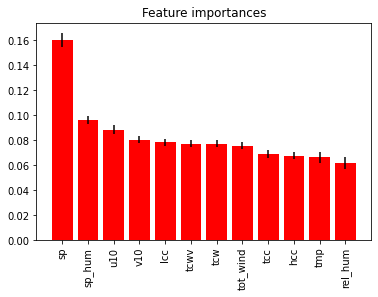

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(df_norm[x_name].shape[1]):
    print("%2d. feature %2d %7s (%.3f)" % (f + 1, indices[f], df_norm[x_name].columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_norm[x_name].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_norm[x_name].shape[1]), df_norm[x_name].columns[indices],rotation=90)
plt.xlim([-1, df_norm[x_name].shape[1]])
plt.show()

##Baseline Performance

In [ ]:
kfolds = KFold(10,shuffle=True,random_state=1234)

model = linear_model.LinearRegression()
scores = cross_val_score(model, df_norm[x_name], df_norm[y_name], cv=kfolds)
#this will be better if we used scaled X and not just x

print("R2 Mean %.3f StdDev %.3f"%(scores.mean(),scores.std()))

R2 Mean 0.044 StdDev 0.001


#Shift -9

In [ ]:
y_9_name = 'EMISSIONS_shif_-9'
df_norm[y_9_name]=df_norm.EMISSIONS_2019.shift(periods=-9)
df_norm=df_norm.dropna(subset = [y_9_name])
df_norm.head()

,EMISSIONS_2019,u10,v10,hcc,lcc,tcc,sp,tmp,sp_hum,rel_hum,tcwv,tcw,tot_wind,EMISSIONS_shif_-9
0,0.000441,0.515923,0.430374,5.551083e-17,0.045595,0.046689,0.923303,0.188289,0.000000,0.63961,0.360875,0.353796,0.304495,0.002588
1,0.000299,0.530493,0.456249,5.551083e-17,0.048083,0.050270,0.921905,0.162800,0.009948,0.67372,0.348015,0.341166,0.284768,0.002251
2,0.000264,0.545064,0.482124,5.551083e-17,0.050570,0.053851,0.920507,0.137311,0.019899,0.70783,0.335154,0.328536,0.265040,0.002109
3,0.000246,0.533036,0.489692,5.551083e-17,0.035199,0.038484,0.921300,0.093933,0.019291,0.79351,0.330104,0.323577,0.247887,0.002215
4,0.000299,0.521008,0.497261,5.551083e-17,0.019827,0.023118,0.922093,0.050552,0.018683,0.87919,0.325053,0.318619,0.230733,0.002357


In [ ]:
forest = ExtraTreesRegressor(n_estimators=100, random_state=0) #Random_state=0 is error because now everytime we run the script we get a different result
forest.fit(df_norm[x_name], df_norm[y_9_name])

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=0, verbose=0, warm_start=False)

Feature ranking:
 1. feature  5      sp (0.168)
 2. feature  7  sp_hum (0.102)
 3. feature  0     u10 (0.082)
 4. feature  1     v10 (0.082)
 5. feature 11 tot_wind (0.078)
 6. feature  3     lcc (0.077)
 7. feature 10     tcw (0.076)
 8. feature  9    tcwv (0.076)
 9. feature  8 rel_hum (0.066)
10. feature  4     tcc (0.066)
11. feature  2     hcc (0.064)
12. feature  6     tmp (0.064)


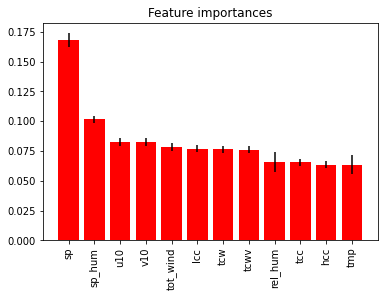

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(df_norm[x_name].shape[1]):
    print("%2d. feature %2d %7s (%.3f)" % (f + 1, indices[f], df_norm[x_name].columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_norm[x_name].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_norm[x_name].shape[1]), df_norm[x_name].columns[indices],rotation=90)
plt.xlim([-1, df_norm[x_name].shape[1]])
plt.show()

Baseline

In [ ]:
kfolds = KFold(10,shuffle=True,random_state=1234)

model = linear_model.LinearRegression()
scores = cross_val_score(model,  df_norm[x_name],  df_norm[y_9_name], cv=kfolds)
#this will be better if we used scaled X and not just x

print("R2 Mean %.3f StdDev %.3f"%(scores.mean(),scores.std()))

R2 Mean 0.068 StdDev 0.002


#Shift 3

In [7]:
y_3_name = 'EMISSIONS_shif_3'
df_norm[y_3_name]=df_norm.EMISSIONS_2019.shift(periods=3)
df_norm=df_norm.dropna(subset = [y_3_name])
df_norm.head()

,EMISSIONS_2019,u10,v10,hcc,lcc,tcc,sp,tmp,sp_hum,rel_hum,tcwv,tcw,tot_wind,EMISSIONS_shif_3
3,0.000246,0.533036,0.489692,5.551083e-17,0.035199,0.038484,0.921300,0.093933,0.019291,0.793510,0.330104,0.323577,0.247887,0.000441
4,0.000299,0.521008,0.497261,5.551083e-17,0.019827,0.023118,0.922093,0.050552,0.018683,0.879190,0.325053,0.318619,0.230733,0.000299
5,0.000530,0.508981,0.504830,5.551083e-17,0.004456,0.007752,0.922886,0.007174,0.018075,0.964870,0.320003,0.313661,0.213580,0.000264
6,0.001701,0.490267,0.519677,4.517825e-02,0.004069,0.052533,0.924268,0.033691,0.034832,0.920449,0.317418,0.311143,0.183961,0.000246
7,0.003102,0.471554,0.534525,9.035651e-02,0.003683,0.097315,0.925650,0.060206,0.051589,0.876028,0.314834,0.308625,0.154342,0.000299


In [8]:
forest = ExtraTreesRegressor(n_estimators=100, random_state=0) #Random_state=0 is error because now everytime we run the script we get a different result
forest.fit(df_norm[x_name], df_norm[y_3_name])

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=0, verbose=0, warm_start=False)

Feature ranking:
 1. feature  5      sp (0.161)
 2. feature  7  sp_hum (0.103)
 3. feature  0     u10 (0.085)
 4. feature  1     v10 (0.081)
 5. feature  3     lcc (0.077)
 6. feature 10     tcw (0.075)
 7. feature  9    tcwv (0.075)
 8. feature 11 tot_wind (0.072)
 9. feature  8 rel_hum (0.069)
10. feature  6     tmp (0.069)
11. feature  4     tcc (0.068)
12. feature  2     hcc (0.066)


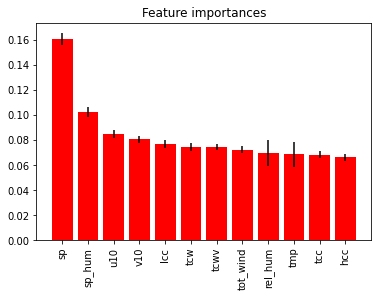

In [9]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(df_norm[x_name].shape[1]):
    print("%2d. feature %2d %7s (%.3f)" % (f + 1, indices[f], df_norm[x_name].columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_norm[x_name].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_norm[x_name].shape[1]), df_norm[x_name].columns[indices],rotation=90)
plt.xlim([-1, df_norm[x_name].shape[1]])
plt.show()

Baseline

In [10]:
kfolds = KFold(10,shuffle=True,random_state=1234)

model = linear_model.LinearRegression()
scores = cross_val_score(model,  df_norm[x_name],  df_norm[y_3_name], cv=kfolds)
#this will be better if we used scaled X and not just x

print("R2 Mean %.3f StdDev %.3f"%(scores.mean(),scores.std()))

R2 Mean 0.060 StdDev 0.002
